In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt

In [23]:
# Load the data
df = pd.read_csv('Churn_Modelling.csv')

In [24]:
# Preprocess the data
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [25]:
# Encode categorical variables
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])


In [26]:
# One-hot encode 'Geography'
df = pd.get_dummies(df, columns=['Geography'], prefix='Geography')

In [27]:
# Prepare features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

In [28]:
# Ensure y is properly encoded as 0 and 1
y = le.fit_transform(y)

In [29]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [30]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [15]:
with open('scaler_test.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [31]:
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


C:\Users\Pranav\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy',Recall(name='recall')])

In [41]:
# Setup callbacks
early_stopping_callback = EarlyStopping(monitor='val_recall', mode='max', patience=20, restore_best_weights=True)

In [42]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [43]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping_callback]
)

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8264 - loss: 0.3544 - recall: 0.8571 - val_accuracy: 0.7900 - val_loss: 0.4573 - val_recall: 0.6742
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.8313 - loss: 0.3366 - recall: 0.8654 - val_accuracy: 0.7700 - val_loss: 0.4696 - val_recall: 0.6629
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.8236 - loss: 0.3525 - recall: 0.8558 - val_accuracy: 0.7600 - val_loss: 0.4790 - val_recall: 0.7022
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8257 - loss: 0.3529 - recall: 0.8784 - val_accuracy: 0.7690 - val_loss: 0.4782 - val_recall: 0.6966
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8262 - loss: 0.3521 - recall: 0.8755 - val_accuracy: 0.7710 - val_loss: 0.4729 - val_recall: 0.6910
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8286 - loss: 0.3504 - recall: 0.8896 - val_accuracy: 0.7780 - val_loss: 0.4596 - val_recall: 0

In [44]:
# Evaluate on the test set
test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.7834 - loss: 0.4371 - recall: 0.7519
Test Accuracy: 0.7660
Test Recall: 0.7628


In [46]:
# Save the best model
best_recall = max(history.history['val_recall'])
best_epoch = history.history['val_recall'].index(best_recall)
print(f"Best validation recall: {best_recall:.4f} at epoch {best_epoch + 1}")
model.save('best_recall_model.keras')

Best validation recall: 0.7191 at epoch 12


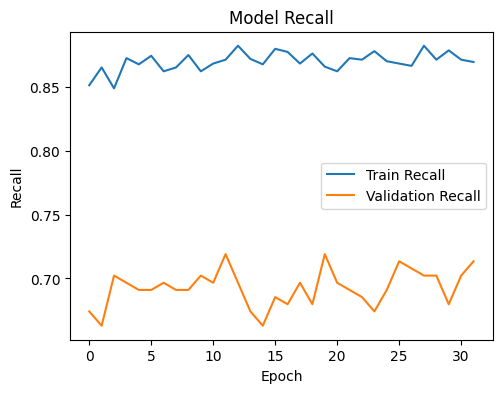

In [47]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

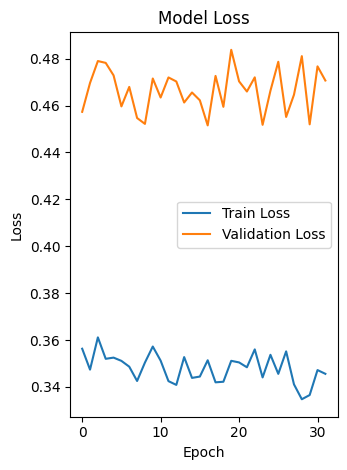

In [48]:
plt.subplot(122)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
# Print available keys in history
print("Available keys in history:")
print(history.history.keys())

Available keys in history:
dict_keys(['accuracy', 'loss', 'recall', 'val_accuracy', 'val_loss', 'val_recall'])


In [57]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [58]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [67]:
cm = confusion_matrix(y_test, y_pred_classes)

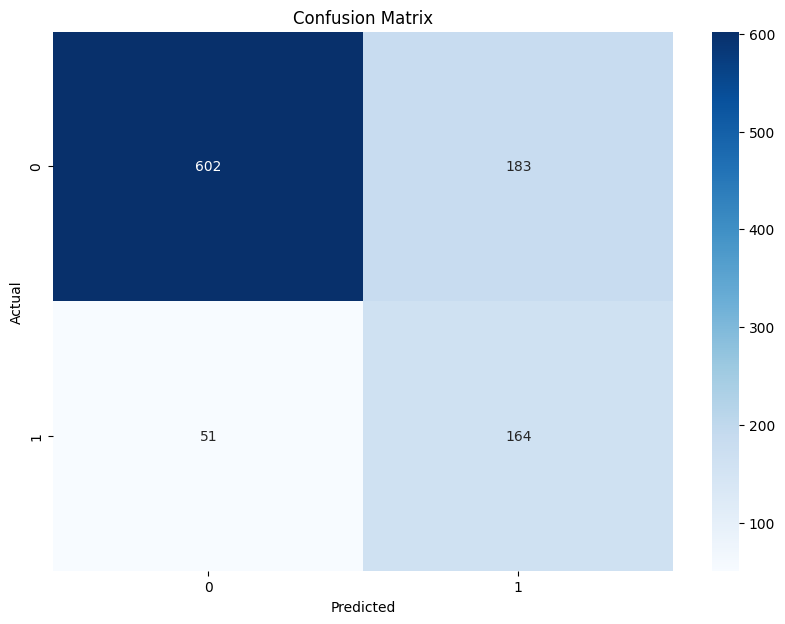

In [68]:
# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [69]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       785
           1       0.47      0.76      0.58       215

    accuracy                           0.77      1000
   macro avg       0.70      0.76      0.71      1000
weighted avg       0.83      0.77      0.78      1000



In [70]:
# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp)

In [71]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Specificity: {specificity:.4f}")

Precision: 0.4726
Recall: 0.7628
F1 Score: 0.5836
Specificity: 0.7669
